In [8]:
import os
import random
import cv2
from matplotlib import pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
train_path = 'dataset/Preprocessed_2DSS/training/coco'
val_path = 'dataset/Preprocessed_2DSS/validation/coco'
test_path = 'dataset/Preprocessed_2DSS/test/coco'

train_json_path = os.path.join(train_path, 'training_coco.json')
val_json_path = os.path.join(val_path, 'validation_coco.json')
test_json_path = os.path.join(test_path, 'test_coco.json')

register_coco_instances("2DSS_train", {}, train_json_path, train_path)
register_coco_instances("2DSS_val", {}, val_json_path, val_path)
register_coco_instances("2DSS_test", {}, test_json_path, test_path)

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("2DSS_train",)
cfg.DATASETS.TEST = ("2DSS_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 6  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 24

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



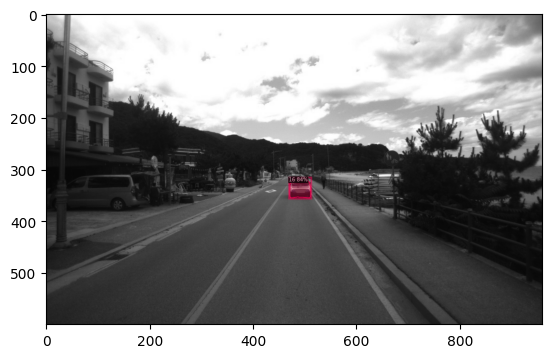

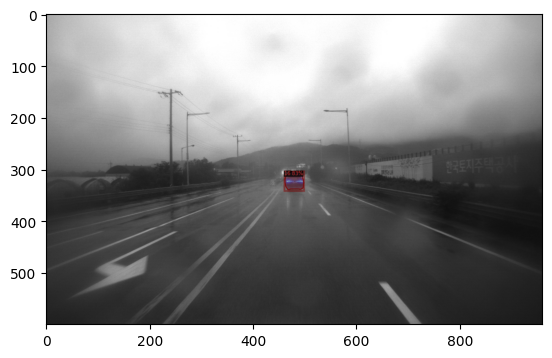

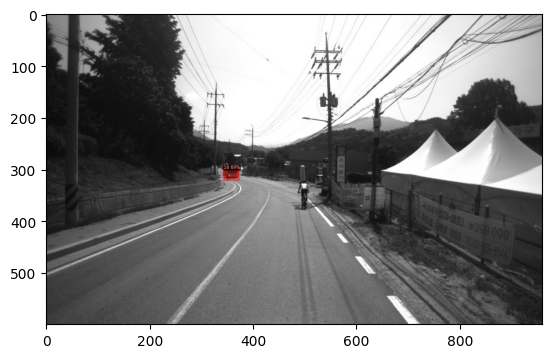

In [30]:
metadata = MetadataCatalog.get(
    cfg.DATASETS.TRAIN[0] if len(cfg.DATASETS.TEST) else "__unused"
)

dataset_dicts = DatasetCatalog.get(
    cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused"
)

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        metadata=metadata, 
        scale=0.5, 
        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #cv2_imshow(out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()